# 数据读入与预处理

In [ ]:
!pip install d2l
!pip instal matplotlib==3.0.0
!pip install matplotlib_inline
from d2l import torch as d2l
import jieba
import os
import tarfile


label_list = ['财经', '彩票', '房产', '股票', '家居', '教育', '科技',
        '社会', '时尚', '时政', '体育', '星座', '游戏', '娱乐']
label_map = {item:index for index, item in enumerate(label_list)}


def stopwords(filepath=None):
    '''获取停用词列表'''
    path='/content/THUCNews/baidu_stopwords.txt' if filepath is None else filepath
    stopwords = [line.strip() for line in open(path, 'r',
                            encoding='utf-8').readlines()]
    return stopwords


def tokenizer(text):
    '''jieba中文分词并过滤停用词'''
    text = jieba.cut(text)
    return [word for word in text if word.strip() not in stop_words]


def read_data(root, is_test):
    news_titles = []
    labels = []
    f = open(root, 'r', encoding='utf-8-sig')
    f = f.readlines()
    for line in f:
        if is_test:
            text = line.strip('\n')
            text = tokenizer(text.strip())
            label = None
            news_titles.append(text)
            labels.append(label)
        else:
            text, label = line.strip('\n').split('\t')
            text = tokenizer(text.strip())
            label = label_map[label]
            news_titles.append(text)
            labels.append(label)
    return news_titles, labels


# 提前全局调用
stop_words = stopwords()
train_data = read_data('/content/THUCNews/train.txt', is_test=False)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.6/112.6 KB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 43.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 44.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 61.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.0/121.0 KB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 KB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 75.8 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.2
    Uninstalling numpy-1.24.2:
      Successfully uninstalled numpy-1.24.2
  Attempting uninstall: pandas
    Found existing installation: pandas 1.3.5
    Uninstalling pandas-1.3.5:
      Successfully uninstalled pandas-1.3.5
  Attempting uninstall: matplotlib


/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
Building prefix dict from the default dictionary ...
DEBUG:jieba:Building prefix dict from the default dictionary ...
Dumping model to file cache /tmp/jieba.cache
DEBUG:jieba:Dumping model to file cache /tmp/jieba.cache
Loading model cost 1.110 seconds.
DEBUG:jieba:Loading model cost 1.110 seconds.
Prefix dict has been built successfully.
DEBUG:jieba:Prefix dict has been built successfully.


In [ ]:
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn


def get_vocab():
    '''获取训练集所有词汇'''
    train_tokens = train_data[0]
    train_tokens = [word for word in train_tokens]
    vocab = d2l.Vocab(train_tokens, min_freq=3, reserved_tokens=['<pad>'])
    return vocab


class THUCNews(Dataset):
    def __init__(self, dataset, num_steps, test, vocab=None):
        self.test = test
        self.vocab = get_vocab() if vocab is None else vocab
        self.num_steps = num_steps

        if test == False:
            text, label = dataset
            self.label = torch.LongTensor(label)
        elif test == True:
            text, _ = dataset
        
        self.text = self._pad(text)

    def __getitem__(self, idx):
        if not self.test:
            return self.text[idx], self.label[idx]
        elif self.test:
            return self.text[idx]

    def _pad(self, lines):
        return torch.Tensor([d2l.truncate_pad(
                   self.vocab[line], self.num_steps, self.vocab['<pad>'])
                   for line in lines])

    def __len__(self):
        return len(self.text)

#生成数据迭代器
图：加载分词和过滤停用词后的标题长度直方图


> 预测时不运行



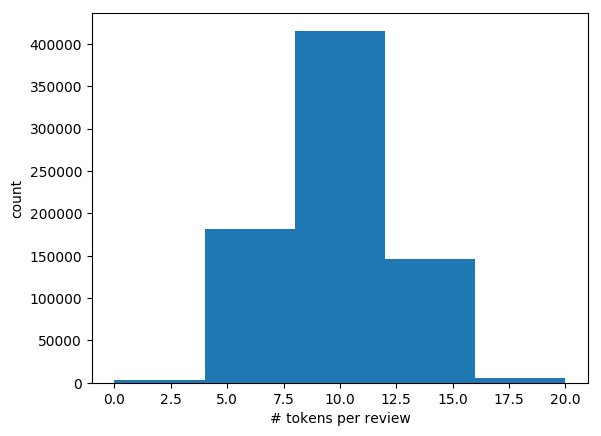

In [ ]:
vocab = get_vocab()
batch_size = 128
num_steps = 13
eval_root = '/content/THUCNews/dev.txt'

train_set = THUCNews(dataset=train_data, num_steps=num_steps, test=False)
eval_set = THUCNews(dataset=read_data(eval_root, is_test=False),
            num_steps=num_steps, test=False)

train_iter = DataLoader(train_set, batch_size=batch_size,
              shuffle=True, num_workers=4)
eval_iter = DataLoader(train_set, batch_size=batch_size,
              shuffle=False, num_workers=4)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


#模型

In [ ]:
class TextCNN(nn.Module):
    def __init__(self, vocab_size, embed_size, kernel_size, 
                 num_channel, num_class, **kwargs):
        super(TextCNN, self).__init__(**kwargs)

        # 这个嵌入层不需要训练
        self.constant_embedding = nn.Embedding(vocab_size, embed_size)
        self.dropout = nn.Dropout(0.15)
        self.liner = nn.Linear(num_channel, num_class)

        # 最大时间汇聚层没有参数，可以共享此实例
        self.pool = nn.AdaptiveMaxPool1d(1)
        self.relu = nn.ReLU()
        # 创建多个一维卷积层
        self.conv = nn.Conv1d(embed_size, num_channel,
                     kernel_size, padding=1)

    def forward(self, x):
        # 每个嵌入层的输出形状都是（批量大小，词元数量，词元向量维度）
        x = x.long()
        x = self.constant_embedding(x)
        # 根据一维卷积层的输入格式，重新排列张量，以便通道作为第2维
        x = x.permute(0, 2, 1)
        # 每个一维卷积层在最大时间汇聚层合并后，获得的张量形状是（批量大小，通道数，1）
        # 删除最后一个维度并沿通道维度连结
        x = torch.squeeze(self.relu(self.pool(self.conv(x))), dim=-1)
        x = self.liner(self.dropout(x))

        return x

#模型初始化


> 预测时不运行



In [ ]:
embed_size, kernel_size, nums_channel, num_class = 100, 3, 100, len(label_list)
devices = d2l.try_all_gpus()
model = TextCNN(len(vocab), embed_size, kernel_size, nums_channel, num_class)


# 线性层权重初始化
def init_weights(m):
    if type(m) in (nn.Linear, nn.Conv1d):
        nn.init.xavier_uniform_(m.weight)

model.apply(init_weights);


# 输入语言为中文时屏蔽此段代码
'''
# 加载预训练词向量
glove_embedding = d2l.TokenEmbedding('glove.6b.100d')
vectors = glove_embedding[vocab.idx_to_token]
model.constant_embedding.weight.data.copy_(vectors)


# 不更新constant_embedding层的权重梯度
model.constant_embedding.weight.requires_grad = False
'''

"\n# 加载预训练词向量\nglove_embedding = d2l.TokenEmbedding('glove.6b.100d')\nvectors = glove_embedding[vocab.idx_to_token]\nmodel.constant_embedding.weight.data.copy_(vectors)\n\n\n# 不更新constant_embedding层的权重梯度\nmodel.constant_embedding.weight.requires_grad = False\n"

#训练、评估并保存模型

> 预测时不运行





loss 0.185, train acc 0.943, test acc 0.961
606.9 examples/sec on [device(type='cpu')]


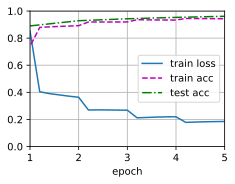

In [ ]:
lr, num_epochs = 0.001, 5
trainer = torch.optim.Adam(model.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="none")
d2l.train_ch13(model, train_iter, eval_iter, loss, trainer, num_epochs, devices)


# 保存模型
torch.save(model.state_dict(), '/content/THUCNews/model_weights.txt')

# 加载测试数据

In [ ]:
test_root = '/content/THUCNews/test.txt'
num_steps, test_batch = 13, 256

test_set = THUCNews(dataset=read_data(test_root, is_test=True),
            num_steps=num_steps, test=True)
test_iter = DataLoader(test_set, batch_size=test_batch,
              shuffle=False, num_workers=4)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# 加载模型参数，输出预测

In [ ]:
embed_size, kernel_size, nums_channel, num_class = 100, 3, 100, len(label_list)
devices = d2l.try_all_gpus()
model = TextCNN(len(vocab), embed_size, kernel_size, nums_channel, num_class)


params = torch.load('/content/THUCNews/model_weights.txt')
model.load_state_dict(params)


label_map_reverse = {value:key for key, value in label_map.items()}
f = open('/content/THUCNews/result.txt', 'w+', encoding='utf-8-sig')


def predict_and_write(model, test_iter):
    model.eval()
    for x in test_iter:
        pred = model(x)
        _, pred = torch.max(pred,1)
        pred = pred.numpy()
        for y_hat in pred:
            label = label_map_reverse[y_hat]
            fw = open('/content/THUCNews/result.txt', 'a+')
            fw.write(label)
            fw.write('\n')

predict_and_write(model, test_iter)
f.close()

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
